<a href="https://colab.research.google.com/github/arjoca/RHDocentes/blob/main/RHDocentes_Futuro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RHDocentes - fevereiro 2022

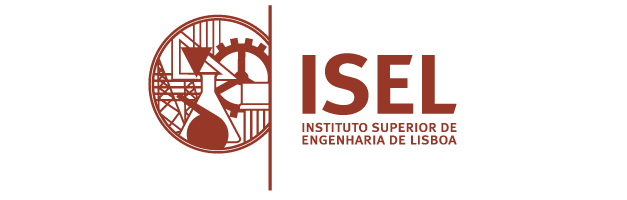

Estudo organizado em 3 notebooks:
*   [O anterior](https://) - Fotografia do ISEL hoje (assimetrias) 
*   Este notebook - Olhar para o Futuro (dinâmica de aposentações)
*   [O próximo e último](https://github.com/arjoca/RHDocentes/blob/main/RHDocentes_Converge.ipynb) - Convergência (correção das assimetrias)

# Fontes de informação

*   Ficheiro "Afetacao_Financeira_ADs_Cursos_2021_v01.xlsx"
*   Ficheiro "RAIDES_0.xlsx"

Informação que depois de filtrada e anonimizada deu origem aos dados guardados no ficheiro [clean_data.xlsx](https://github.com/arjoca/RHDocentes/blob/main/clean_data.xlsx), usados neste estudo.

# Preparação

## Importação de módulos e leitura de dados

In [1]:
# Instalação de módulos
!pip install kora -q
!pip install -U kaleido

In [2]:
# Importação de módulos
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from ipywidgets import widgets, interact
from IPython.display import Image

In [3]:
# Leitura de dados
base_url = 'https://raw.githubusercontent.com/arjoca/RHDocentes/main/data/'
docentes = pd.read_csv(base_url + 'docentes.csv', encoding= 'unicode_escape', 
                       parse_dates=['Data Nascimento'], infer_datetime_format=True)
alunos_per_curso = pd.read_csv(base_url + 'alunos.csv', encoding= 'unicode_escape', index_col=0)
horas = pd.read_csv(base_url + 'horas.csv', encoding= 'unicode_escape', index_col=0)

## Inicializações

In [4]:
# Visualizar dataframes como tabelas interativas
%load_ext google.colab.data_table

In [5]:
# Designações dos cursos e departamentos
LISTA_DEPTS = sorted(docentes['Departamento'].unique())
LISTA_CURSOS = sorted(alunos_per_curso.index.unique())

In [6]:
# Designações das categorias de docentes
cat_prof_coord = ['Prof. Coordenador', 'Prof. Coordenador c/ Agreg. ', 'Professor Coordenador Principal']
cat_convidado = ['Assistente Convidado', 'Professor Adjunto Convidado']
cat_adjunto = ['Professor Adjunto']
cat_assistente = ['Assistente do 2. Trienio', 'Assistente', 'Equiparado Assistente 2. Trienio']
cat_monitor = ['Monitor']
cat_quadro = cat_prof_coord + cat_adjunto
cat_todas = cat_quadro + cat_convidado + cat_assistente + cat_monitor

In [7]:
# Horas de contacto usadas para determinar relações entre cursos e departamentos
horas_per_curso = horas.sum(axis=1)
pesos_dept_per_curso = horas.T / horas_per_curso

# Alunos por departamento
alunos_per_dept = pd.DataFrame(np.dot(pesos_dept_per_curso, alunos_per_curso),
                              index=pesos_dept_per_curso.index, columns=['Alunos'])
alunos_per_dept = alunos_per_dept['Alunos']
alunos_per_dept.name = ''
alunos_per_dept = alunos_per_dept.sort_index()

## Definição de funções

In [8]:
# Filtragem de docentes atendendo à sua idade de aposentação 
def aposentados_e_ativos(df, ano, idade_reforma):
  idade = (datetime(ano, 1, 1) - df['Data Nascimento'])/timedelta(days=365.25)
  aposentados = df[idade > idade_reforma]
  ativos = df.drop(index=aposentados.index)
  return aposentados, ativos

In [9]:
# Filtragem de docentes atendendo à sua categoria
def docentes_per_categoria(df, categoria):
  s = df.groupby(['Departamento', 'Categoria'])['ETI'].sum()
  s = s.loc[(slice(None), categoria)].droplevel(level=1)
  s = s.groupby(s.index).sum()
  s = pd.Series(s, index=LISTA_DEPTS)
  return s.fillna(0)

In [10]:
# Gráfico simples com barras/tabela e linha de referência
def plot_table_series(s, title='', ref=None, size=(12,3)):
  fig, ax = plt.subplots(1, 1, figsize=size)
  s.name = ''
  df = s.to_frame()
  df.plot(kind='bar', table=np.round(df.T, 1), ax=ax, legend=None)
  if ref is not None:
    ax.axhline(y=ref, linewidth=2, color='#d62728')
  ax.xaxis.set_visible(False)
  ax.set_title(title);

# Olhar para o Futuro

In [11]:
ANOS = 10
LST_ANOS = range(2022, 2022+ANOS+1)

## Evolução do Número de Alunos

**Hipótese:** Vai-se manter tudo igual 

Será assim?

Quais as áreas onde se prevê acréscimo de procura?

Criação de Departamento de Informática?

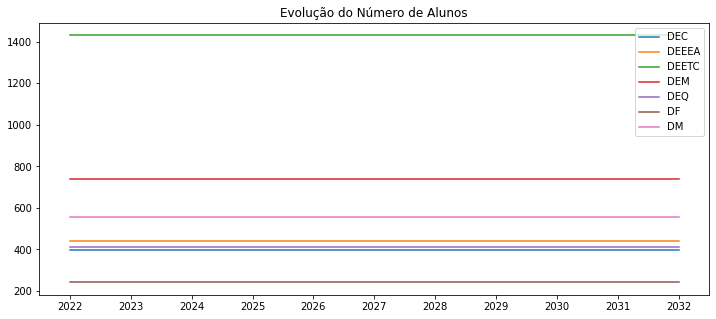

In [12]:
# Evolução do número de alunos
df = pd.DataFrame([alunos_per_dept.values for ano in LST_ANOS], 
                  columns=alunos_per_dept.index, index=LST_ANOS)
fig, ax = plt.subplots(1, 1, figsize=(12,5))
ax.set_xticks(LST_ANOS)
ax.set_title('Evolução do Número de Alunos')
df.plot(ax=ax);

## Evolução dos recursos docentes (dinâmica de aposentações)

In [13]:
IDADE_REFORMA = 70

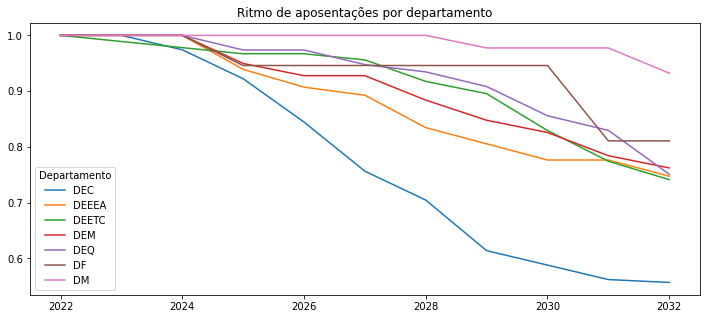

In [14]:
# Ritmo de aposentações
df = pd.DataFrame([docentes.groupby(['Departamento'])['ETI'].sum()], 
                  index=['2022'])
for ano in LST_ANOS[1:]:
  ap, at = aposentados_e_ativos(docentes, ano, IDADE_REFORMA)
  s = at.groupby(['Departamento'])['ETI'].sum()
  s.name = str(ano)
  df = df.append(s)

percentage = df /df.loc[str(2022)]
fig, ax = plt.subplots(1, 1, figsize=(12,5))
ax.set_title('Ritmo de aposentações por departamento')
percentage.plot(ax=ax);

In [15]:
# Ritmo de aposentações na categoria
catgs = {'Coordenadores':cat_prof_coord, 
         'Adjuntos': cat_adjunto,
         'Quadro': cat_quadro,
         'Convidados': cat_convidado,
         'Todas': cat_todas}
inv_catgs = {tuple(v): k for k, v in catgs.items()}
@interact(categoria=widgets.Dropdown(options=catgs, value=cat_prof_coord))
def f(categoria):
  df = pd.DataFrame([docentes_per_categoria(docentes, categoria)], 
                    index=['2022'], columns=LISTA_DEPTS)
  for ano in LST_ANOS[1:]:
    ap, at = aposentados_e_ativos(docentes, ano, IDADE_REFORMA)
    s = docentes_per_categoria(at, categoria)
    s.name = str(ano)
    df = df.append(s)

  percentage = df /df.loc[str(2022)]
  fig, ax = plt.subplots(1, 1, figsize=(12, 5))
  percentage.plot(ax=ax)
  ax.set_title(f'Ritmo de aposentações na categoria de {inv_catgs[tuple(categoria)]}');
  fig.savefig('temp_image.png')

interactive(children=(Dropdown(description='categoria', options={'Coordenadores': ['Prof. Coordenador', 'Prof.…

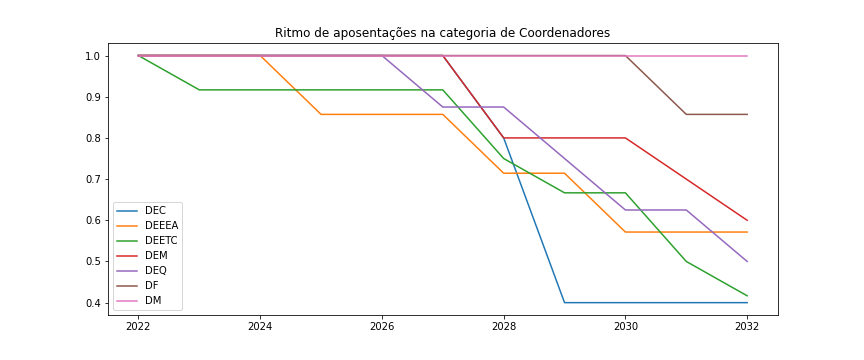

In [20]:
# Figura estática
Image('temp_image.png')

Evolução dos Rácios
Alunos/ETI
Coordenador/ETI 

NameError: ignored

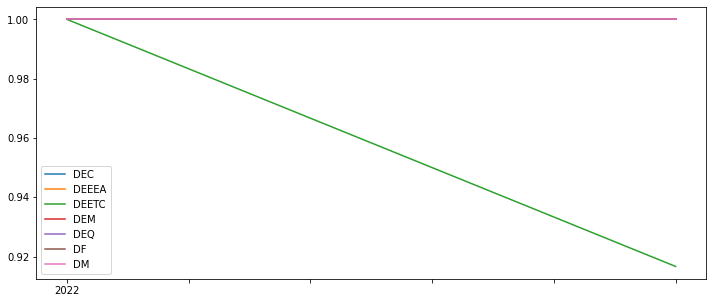

In [19]:
# Rácio Coordenadores/ETI
df = pd.DataFrame([docentes_per_categoria(docentes, cat_prof_coord)], 
                    index=['2022'])
for ano in LST_ANOS[1:]:
  ap, at = aposentados_e_ativos(docentes, ano, IDADE_REFORMA)
  s = docentes_per_categoria(at, cat_prof_coord)
  s.name = str(ano)
  df = df.append(s)

  percentage = df /df.loc[str(2022)]
  fig, ax = plt.subplots(1, 1, figsize=(12, 5))
  percentage.plot(ax=ax)
  ax.set_title(f'Ritmo de aposentações na categoria de {inv_catgs[tuple(categoria)]}');
  fig.savefig('temp_image.png')